# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
# импорт необходимых библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.utils import shuffle

### Получение общих сведений о данных

In [2]:
# чтение файла с данными и сохранение в df
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
# получение первых 10 строк таблицы df
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [4]:
# получение общей информации о данных в таблице df
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак
- Exited — факт ухода клиента

Исходные данные содержат 13 признаков 10 000 наблюдений. Признаки RowNumber, RowNumber и Surname не содержат полезной для моделирования информации, их удалим. Также устраним нарушения стиля в наименовании столбцов.

In [5]:
#удаление столбцов
df = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [6]:
#переименование столбцов
df.rename(columns = {'CreditScore' : 'Credit_Score',
                     'NumOfProducts' : 'Num_Of_Products',
                      'HasCrCard' : 'Has_Cr_Card',
                     'IsActiveMember' : 'Is_Active_Member',
                     'EstimatedSalary' : 'Estimated_Salary'}, inplace = True)

df.columns = [x.lower() for x in df.columns]

In [7]:
# подсчет дубликатов
df.duplicated().sum()

0

### Изучение значений

Для начала изучим диапазоны значений численных признаков (credit_score, balance, estimated_salary и age)

In [8]:
#создание описательной статистики
df[['credit_score', 'balance', 'estimated_salary', 'age']].describe()

,credit_score,balance,estimated_salary,age
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,76485.889288,100090.239881,38.921800
std,96.653299,62397.405202,57510.492818,10.487806
min,350.000000,0.000000,11.580000,18.000000
25%,584.000000,0.000000,51002.110000,32.000000
50%,652.000000,97198.540000,100193.915000,37.000000
75%,718.000000,127644.240000,149388.247500,44.000000
max,850.000000,250898.090000,199992.480000,92.000000


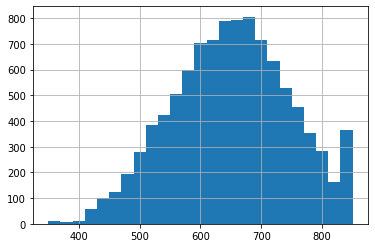

In [9]:
#построение гистограммы credit_score
df['credit_score'].hist(bins=25);

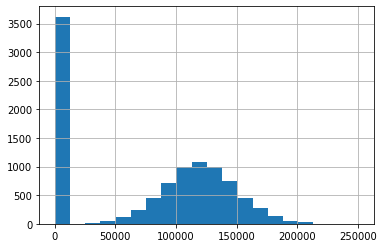

In [10]:
#построение гистограммы balance
df['balance'].hist(bins=20);

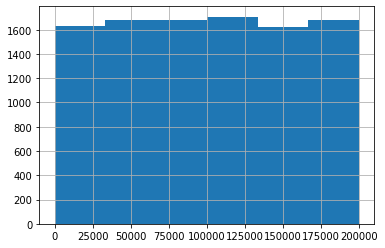

In [11]:
#построение гистограммы estimated_salary
df['estimated_salary'].hist(bins=6);

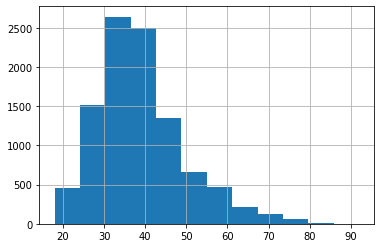

In [12]:
#построение гистограммы age
df['age'].hist(bins=12);

В столбце balance наблюдается значительное количество (около 30%) нулевых значений, искажающих общую картину распределения. Учитывая их большое количество, а также значимость признака, их удаление или замена не целесообразна.

Необходимо отмасштабировать значения столбцов balance и estimated_salary

Значения столбца age необходимо категоризовать.

В целях проведения категоризации учтем, что возрастное деление клиентуры банка связано с понятием «жизненного цикла» людей – последовательных стадий, которые проходит личность в течение жизни, каждой из которых обычно присущи определенные потребности, а значит и использование определенных банковских продуктов.
Исходя из этой логики выделим следующие категории:

- 1 (18 - 25 лет): люди впервые нанимающиеся на работу, готовящиеся вступить в брак,
- 2 (25 - 35 лет): люди, недавно образовавшие семью,
- 3 (35 - 45 лет): люди, впервые покупающие дом и потребительские товары длительного пользования,
- 4 (45 - 55 лет): люди «зрелого возраста», имеющие рост дохода по мере снижения финансовых обязательств,
- 5 (старше 55 лет): люди, имеющие накопленный капитал и стремщиеся обеспечить его сохранность и настоящий устойчивый доход.

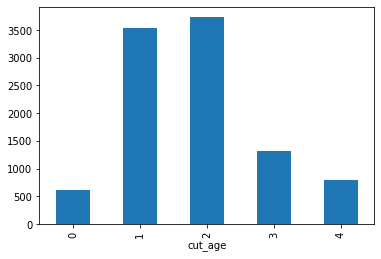

In [13]:
#категоризация столбца age
cut_labels = [0, 1, 2, 3, 4]
cut_bins = [0, 25, 35, 45, 55, 100]

df['cut_age'] = pd.cut(df['age'], bins=cut_bins, labels=cut_labels)
df.groupby('cut_age')['cut_age'].count().plot(kind='bar', y='cut_age');

In [14]:
#удаление исходного столбца age
df = df.drop(['age'], axis=1)

В столбце tenure имеется значительное количество пропущенных значений. Целесообразно заполнение пропущенных значений медианой, вычисленной по столбцу. 

In [15]:
#заполнение пропущенных значений
med = df['tenure'].median()
df['tenure'] = df['tenure'].fillna(med)

In [16]:
#получение значений столбца
df['tenure'].value_counts().sort_index(ascending=True)

0.0      382
1.0      952
2.0      950
3.0      928
4.0      885
5.0     1836
6.0      881
7.0      925
8.0      933
9.0      882
10.0     446
Name: tenure, dtype: int64

In [17]:
#получение значений столбца
df['num_of_products'].value_counts().sort_index(ascending=True)

1    5084
2    4590
3     266
4      60
Name: num_of_products, dtype: int64

Далее изучим категориальные признаки (geography, gender, has_cr_card, is_active_member и exited)

In [18]:
#получение значений столбца
df['geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

In [19]:
#получение значений столбца
df['gender'].value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

In [20]:
#получение значений столбца
df['has_cr_card'].value_counts()

1    7055
0    2945
Name: has_cr_card, dtype: int64

In [21]:
#получение значений столбца
df['is_active_member'].value_counts()

1    5151
0    4849
Name: is_active_member, dtype: int64

In [22]:
#получение значений столбца
df['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

В отношении признаков geography и gender требуется кодирование.

В отношении целевого признака наблюдается значительный дисбаланс классов.

### Кодирование признаков

Преобразуем категориальные номинальные признаки geography и gender в численные с помощью техники прямого кодирования One-Hot Encoding, а категориальный ординальный признак cut_age - с помощью техники OrdinalEncoder.

In [23]:
#кодирование признака geography
df[['geography_g', 'geography_s']] = pd.get_dummies(df['geography'], drop_first=True)
df = df.drop(['geography'], axis=1)

In [24]:
#кодирование признака gender
df['gender'] = pd.get_dummies(df['gender'], drop_first=True)

### Подготовка выборок

Разобъем исходные данные на три части: обучающую, валидационную и тестовую в соотношении 3:1:1.

In [26]:
#разбиение данных на выборки
df_train, df_valid_test = train_test_split(df, test_size=0.4, random_state=1)
df_valid, df_test = train_test_split(df_valid_test, test_size=0.5, random_state=1)

In [27]:
#вывод размеров таблиц
df_train.shape, df_valid.shape, df_test.shape

((6000, 12), (2000, 12), (2000, 12))

In [28]:
#выделение признаков и целевого признака обучающей выборки
features_train = df_train.drop(['exited'], axis=1)
target_train = df_train['exited']

In [29]:
#выделение признаков и целевого признака валидационной выборки
features_valid = df_valid.drop(['exited'], axis=1)
target_valid = df_valid['exited']

In [30]:
#выделение признаков и целевого признака тестовой выборки
features_test = df_test.drop(['exited'], axis=1)
target_test = df_test['exited']

### Масштабирование признаков

Масштабируем признаки balance и estimated_salary. Для масштабирования применим метод стандартизации данных.

In [31]:
#настройка параметров масштабирования
numeric = ['balance', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [32]:
#стандартизация обучающей выборки
features_train[numeric] = scaler.transform(features_train[numeric])

In [33]:
#стандартизация валидационной выборки
features_valid[numeric] = scaler.transform(features_valid[numeric])

In [34]:
#стандартизация тестовой выборки
features_test[numeric] = scaler.transform(features_test[numeric])

### Вывод

Изучены исходные данные. Проведена необходимая предобработка:
- удалены признаки RowNumber, CustomerId и Surname,
- заполнены пропущенные значения признака tenure медианой по столбцу,
- закодированы признаки geography, gender и age
- отмасштабированы признаки balance и estimated_salary,
- данные разбиты на три части: обучающую, валидационную и тестовую.

Данных достаточно для построения модели, однако наблюдается значительный дисбаланс классов целевого признака.

## Исследование задачи

Для решения задачи бинарной классификации воспользуемся алгоритмами:
- LogisticRegression
- RandomForest

Для выявления оптимальной модели воспользуемся метриками классификации F1-мера и AUC-ROC

### Классификация с помощью логистической регрессии

In [35]:
# обучение модели
model_log_reg = LogisticRegression(random_state=1, solver='liblinear')
model_log_reg.fit(features_train, target_train)
predicted_valid = model_log_reg.predict(features_valid)
f1_log_reg = f1_score(target_valid, predicted_valid)

f1_log_reg

0.3745583038869258

F1-мера обученной модели на валидацинной выборке достигает значения 0,38.

In [36]:
#вычисление вероятностей классов
probabilities_valid_log_reg = model_log_reg.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid_log_reg[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

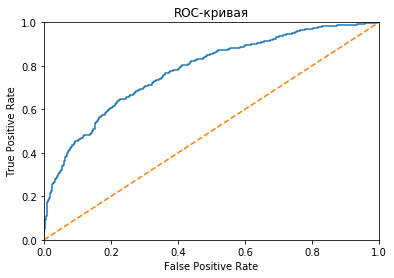

In [37]:
#построение ROC-кривой
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='--')# ROC-кривая случайной модели
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [38]:
#получение значения auc_roc
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

0.7778849176919755

AUC-ROC обученной модели на валидацинной выборке достигает значения 0,78.

### Классификация с помощью случайного леса

In [39]:
%%time
# подбор наилучших гиперпараметров модели
best_model_forest = None
best_result = 0
best_depth = 0
for depth in range (1, 16, 1):
    model_forest = RandomForestClassifier(random_state=1, n_estimators=20, max_depth=depth)
    model_forest.fit(features_train, target_train)
    predicted_valid = model_forest.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model_forest = model_forest
        best_result = result
        best_depth = depth     
                
best_result, best_depth

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


CPU times: user 1.63 s, sys: 2.31 ms, total: 1.63 s
Wall time: 1.63 s


(0.5602409638554217, 15)

In [40]:
%%time
# подбор наилучших гиперпараметров модели
best_model_forest = None
best_result = 0
best_est = 0
for est in range (1, 501, 10):
    model_forest = RandomForestClassifier(random_state=1, n_estimators=est, max_depth=15)
    model_forest.fit(features_train, target_train)
    predicted_valid = model_forest.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model_forest = model_forest
        f1_score_forest = result
        best_est = est     
                
f1_score_forest, best_est

CPU times: user 1min 26s, sys: 650 ms, total: 1min 27s
Wall time: 1min 28s


(0.5753012048192772, 491)

F1-мера обученной модели на валидацинной выборке достигает значения 0,57. Гиперпараметры при этом имеют следующие значения: число деревьев - 491, максимальная глубина дерева - 15.

In [41]:
best_model_forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=491,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [42]:
best_model_forest.fit(features_train, target_train)
predicted_valid = best_model_forest.predict(features_valid)
f1_score_forest = f1_score(target_valid, predicted_valid)

In [43]:
#получение значений precision и recall
precision_score_forest = precision_score(target_valid, predicted_valid)
recall_score_forest = recall_score(target_valid, predicted_valid)

In [44]:
#вычисление вероятностей классов
probabilities_valid_forest = best_model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid_forest[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

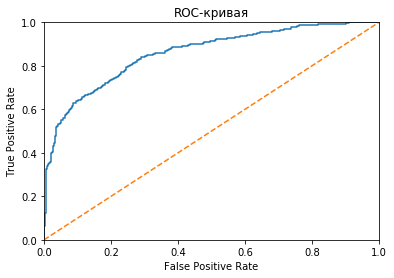

In [45]:
#построение ROC-кривой
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='--')# ROC-кривая случайной модели
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [46]:
#получение значения auc_roc
auc_roc_forest = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc_forest

0.8580372736585741

AUC-ROC обученной модели на валидацинной выборке достигает значения 0,86.

### Вывод

Прооведено исследование моделей:
- логистическая регрессия (F1-мера 0,38, AUC-ROC 0,78)
- случайный лес (F1-мера 0,57, AUC-ROC 0,86),

Наилучший результат на валидационной выборке показала модель случайного леса. Гиперпараметры при этом имеют следующие значения: число деревьев - 491, максимальная глубина дерева - 15. Далее работаем с этой моделью. 

## Борьба с дисбалансом

In [47]:
#соотношение классов целевого признака
df['exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

Значения целевого признака exited не сбалансированы. Соотношение отрицательных и положительных значений 4:1. 

Для повышения качества модели проведем балансировку классов следующими способами:
- автоматическая корректировка весов классов с помощью режима balanced параметра class_weight,
- увеличение выборки с помощью техники upsampling,
- уменьшение выборки с помощью техники downsampled.

По результатам обучения модели каждым из предложенных способов, оценим качество обученной модели метриками:
- f1 (сохраним в переменные f1_score_balanced, f1_score_up и f1_score_down соответственно),
- precision (precision_score_balanced, precision_score_up и precision_score_down),
- recall (recall_score_balanced, recall_score_up и recall_score_down),
- roc_auc (auc_roc_balanced, auc_roc_up и auc_roc_down).

Метрики качества модели, обученной на несбалансированной выборке определены в пункте 2.2 исследования и сохранены в переменных f1_score_forest, precision_score_forest, recall_score_forest и auc_roc_forest.

### Использование режима balanced

In [48]:
#получение структуры модели
model_result = RandomForestClassifier(random_state=1, n_estimators=491, max_depth=15, class_weight='balanced')

In [49]:
# обученние модели
model_result.fit(features_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=491, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)

In [50]:
#получение значения f1-меры
predicted_valid = model_result.predict(features_valid)
f1_score_balanced = f1_score(target_valid, predicted_valid)
f1_score_balanced

0.5953079178885631

In [51]:
#получение значений precision и recall
precision_score_balanced = precision_score(target_valid, predicted_valid)
recall_score_balanced = recall_score(target_valid, predicted_valid)

In [52]:
#получение значения auc_roc
probabilities_valid = model_result.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_balanced = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc_balanced

0.8543712834275279

### Увеличение выборки

In [53]:
#деление обучающей выборки на отрицательные и положительные объекты
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

Учитывая соотношение отрицательных и положительных значений целевого признака (4:1) целесообразно увеличить количество положительных объектов в 4 раза.

In [54]:
#сборка сбалансированных выборок
features_upsampled = pd.concat([features_zeros] + [features_ones] * 4)
target_upsampled = pd.concat([target_zeros] + [target_ones] * 4)

In [55]:
#перемешивание данных
features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=1)

In [56]:
#обучение модели на сбалансированных признаках
model_result.fit(features_upsampled, target_upsampled)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=491, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)

In [57]:
#получение значения f1-меры
predicted_valid = model_result.predict(features_valid)
f1_score_up = f1_score(target_valid, predicted_valid)
f1_score_up

0.6352357320099256

In [58]:
#получение значений precision и recall
precision_score_up = precision_score(target_valid, predicted_valid)
recall_score_up = recall_score(target_valid, predicted_valid)

In [59]:
#получение значения auc_roc
probabilities_valid = model_result.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_up = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc_up

0.8515928328913186

### Уменьшение выборки

Учитывая соотношение отрицательных и положительных значений целевого признака (4:1) целесообразно уменьшить количество отрицательных объектов в 0.3 раза.

In [60]:
#сборка сбалансированных выборок
features_downsampled = pd.concat([features_zeros.sample(frac=0.3, random_state=1)] + [features_ones])
target_downsampled = pd.concat([target_zeros.sample(frac=0.3, random_state=1)] + [target_ones])

In [61]:
#перемешивание данных
features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=1)

In [62]:
#обучение модели на сбалансированных признаках
model_result.fit(features_downsampled, target_downsampled)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=491, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)

In [63]:
#получение значения f1-меры
predicted_valid = model_result.predict(features_valid)
f1_score_down = f1_score(target_valid, predicted_valid)
f1_score_down

0.6046046046046046

In [64]:
#получение значений precision и recall
precision_score_down = precision_score(target_valid, predicted_valid)
recall_score_down = recall_score(target_valid, predicted_valid)

In [65]:
#получение значения auc_roc
probabilities_valid = model_result.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_down = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc_down

0.8473040605693191

### Вывод

Соберем все полученные метрики качества модели в сводную таблицу. Изучим получившийся результат.

In [66]:
#подготовка сводной таблицы
d = {"f1_score":pd.Series([f1_score_forest, f1_score_balanced, f1_score_up, f1_score_down], index=['no_balanced', 'balanced', 'upsampled', 'downsampled']),
     "auc_roc": pd.Series([auc_roc_forest, auc_roc_balanced, auc_roc_up, auc_roc_down], index=['no_balanced', 'balanced', 'upsampled', 'downsampled']),
     "precision_score":pd.Series([precision_score_forest, precision_score_balanced, precision_score_up, precision_score_down], index=['no_balanced', 'balanced', 'upsampled', 'downsampled']),
     "recall_score":pd.Series([recall_score_forest, recall_score_balanced, recall_score_up, recall_score_down], index=['no_balanced', 'balanced', 'upsampled', 'downsampled'])}

pivot = pd.DataFrame(d)
pivot.round(decimals=2).style

,f1_score,auc_roc,precision_score,recall_score
no_balanced,0.58,0.86,0.79,0.45
balanced,0.6,0.85,0.78,0.48
upsampled,0.64,0.85,0.66,0.61
downsampled,0.6,0.85,0.52,0.72


Наивысшее значение f1-меры (0.64) получено на модели, обученной на выборке сбалансированной с помощью техники upsampling, однако наивысшее значение auc_roc (0.86) получено при обучении модели на несбалансированной выборке.
Определим какая метрика качества модели будет первостепенной.

В случае несбалансированности классов целевого признака метрика auc_roc не показательна - ее высокие значения в нашем случае обусловлены высоким значением точности (precision 0.79) в ущерб полноте (recall 0.45). После обучения модели на сбалансированной выборке значение точности снижается, а значение полноты повышается. Это явление лучшим образом учитывает метрика f1

Тестировать целесообразно модель, обученную на выборке сбалансированной с помощью техники upsampling, она выдает средние значения точности (precision 0.66) и полноты (recall 0.61) и имеет наибольший показатель f1-меры.

## Тестирование модели

In [67]:
#вызов параметров модели
model_result

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=491, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)

In [68]:
# объединение тренировочной и валидационной выборок для лучшего обучения
df_train_valid = pd.merge(df_train, df_valid, how='outer')
df_train_valid.shape

(8000, 12)

In [69]:
#выделение признаков и целевого признака совмещенной обучающей выборки
features_train_valid = df_train_valid.drop(['exited'], axis=1)
target_train_valid = df_train_valid['exited']

In [70]:
#стандартизация совмещенной обучающей выборки
features_train_valid[numeric] = scaler.transform(features_train_valid[numeric])

In [71]:
#деление совмещенной обучающей выборки на отрицательные и положительные объекты
features_zeros = features_train_valid[target_train_valid == 0]
features_ones = features_train_valid[target_train_valid == 1]
target_zeros = target_train_valid[target_train_valid == 0]
target_ones = target_train_valid[target_train_valid == 1]

In [72]:
#сборка сбалансированных выборок
features_upsampled = pd.concat([features_zeros] + [features_ones] * 4)
target_upsampled = pd.concat([target_zeros] + [target_ones] * 4)

In [73]:
#перемешивание данных
features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=1)

In [74]:
#обучение модели на сбалансированных признаках
model_result.fit(features_upsampled, target_upsampled)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=491, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)

In [75]:
#получение значения f1-меры
predicted_test = model_result.predict(features_test)
f1_score_test = f1_score(target_test, predicted_test)
f1_score_test

0.616774193548387

In [76]:
#получение значения auc_roc
probabilities_test = model_result.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc_test = roc_auc_score(target_test, probabilities_one_test)
auc_roc_test

0.8496473779385173

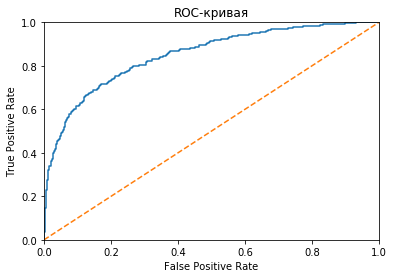

In [77]:
#построение ROC-кривой
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='--')# ROC-кривая случайной модели
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Вывод

F1-мера обученной модели на тренировочной выборке достигает значения 0,62, значение auc_roc - 0,85

## Общий вывод

В целях прогнозирования оттока клиентов из банка изучены исторические данные о поведении клиентов и расторжении договоров с банком.

Проведено исследовние различных моделей машинного обучения. 

Наилучший результат на валидационной выборке (F1-мера = 0,60) показала модель случайного леса с гипепарамрами: число деревьев - 491, максимальная глубина дерева - 15 с применением автоматической корректировки весов классов с помощью режима balanced параметра class_weight.

Для повышения качества модели проведена балансировка классов путем увеличения выборки с помощью техники upsampling. В результате значение F1-меры модели на валидационной выборке увеличено до 0.64.

Значение F1-меры на тестовой выборке для даной модели - 0,62, значение auc_roc - 0,85.